In [1]:
import gc
import os
from pathlib import Path
import random
import sys

from tqdm import tqdm_notebook as tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML


# --- models ---
from sklearn import preprocessing
from sklearn.model_selection import KFold
import lightgbm as lgb
import catboost as cb

from sklearn.metrics import mean_squared_error

In [2]:
sub1='SckCat_1'
#_noBuilding_Rm3
sub2='SCK'
    

In [3]:
%%time
root = Path('./')

train_df = pd.read_feather(root/'train.feather')
test_df = pd.read_feather(root/'test.feather')
weather_train_df = pd.read_feather(root/'weather_train.feather')
weather_test_df = pd.read_feather(root/'weather_test.feather')
building_meta_df = pd.read_feather(root/'building_metadata.feather')

CPU times: user 222 ms, sys: 277 ms, total: 499 ms
Wall time: 291 ms


In [4]:
leak_df = pd.read_feather('./leak-v3.feather')

leak_df.fillna(0, inplace=True)
leak_df = leak_df[(leak_df.timestamp.dt.year > 2016) & (leak_df.timestamp.dt.year < 2019)]
leak_df.loc[leak_df.meter_reading < 0, 'meter_reading'] = 0 # 将负值改成0
leak_df = leak_df[leak_df.building_id!=245]
print(len(leak_df))
leak_df.drop(leak_df[leak_df.building_id<=104].index,inplace=True)
print(len(leak_df))

12059979
9799899


In [5]:
sample_submission1 = pd.read_csv(sub1+'.csv', index_col=0)
sample_submission2 = pd.read_csv(sub2+'.csv', index_col=0)

/home/artemis874/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [6]:
test_df['pred1'] = sample_submission1.meter_reading
test_df['pred2'] = sample_submission2.meter_reading
leak_df = leak_df.merge(test_df[['building_id', 'meter', 'timestamp', 'pred1', 'pred2', 'row_id']], left_on = ['building_id', 'meter', 'timestamp'], right_on = ['building_id', 'meter', 'timestamp'], how = "left")
leak_df = leak_df.merge(building_meta_df[['building_id', 'site_id']], on='building_id', how='left')
leak_df['pred1_l1p'] = np.log1p(leak_df.pred1)
leak_df['pred2_l1p'] = np.log1p(leak_df.pred2)
leak_df['meter_reading_l1p'] = np.log1p(leak_df.meter_reading)

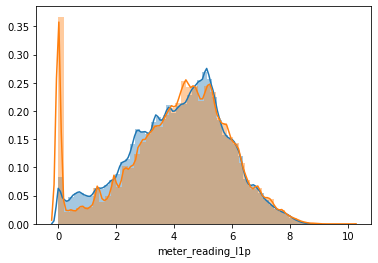

score1= 0.8657839434005078


In [7]:
plt.figure()
sns.distplot(leak_df.pred1_l1p)
sns.distplot(leak_df.meter_reading_l1p)
plt.show()
leak_score = np.sqrt(mean_squared_error(leak_df.pred1_l1p, leak_df.meter_reading_l1p))
print ('score1=', leak_score)

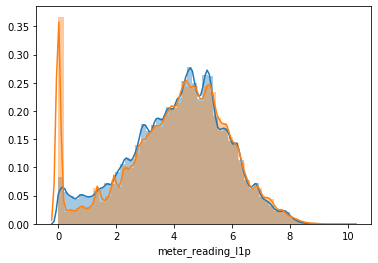

score2= 0.8719346674035384


In [8]:
plt.figure()
sns.distplot(leak_df.pred2_l1p)
sns.distplot(leak_df.meter_reading_l1p)
plt.show()
leak_score = np.sqrt(mean_squared_error(leak_df.pred2_l1p, leak_df.meter_reading_l1p))
print ('score2=', leak_score)

In [9]:
N = 100
leak_df['pred1'].mean()

201.13439226047285

In [10]:
#correct weight1
scores = np.zeros(3*N,)
for i in range(3*N):
    p = i * 1./(N*10)
    v =  (p+0.85) *leak_df['pred1'].values
    vl1p = np.log1p(v)
    scores[i] = np.sqrt(mean_squared_error(vl1p, leak_df.meter_reading_l1p))
best_weight_1 = (np.argmin(scores) *  1./(N*10))+0.85
print(scores.min(), best_weight_1)

0.8614762999772251 0.9119999999999999


In [11]:
#correct weight2
scores = np.zeros(3*N,)
for i in range(3*N):
    p = i * 1./(N*10)
    v = (p+0.85) *leak_df['pred2'].values
    vl1p =  np.log1p(v)
    scores[i] = np.sqrt(mean_squared_error(vl1p, leak_df.meter_reading_l1p))
best_weight_2 = (np.argmin(scores) *  1./(N*10))+0.85
print(scores.min(), best_weight_2)

0.8667091782580343 0.904


In [12]:
N = 100
scores = np.zeros(N,)
for i in range(N):
    p = i * 1./N
    v = p * best_weight_1*(leak_df['pred1'].values) + (1.-p)*best_weight_2*leak_df ['pred2'].values
    vl1p = np.log1p(v)
    scores[i] = np.sqrt(mean_squared_error(vl1p, leak_df.meter_reading_l1p))
best_weight = np.argmin(scores) *  1./N
print (scores.min(), best_weight)

0.8604375275877371 0.7


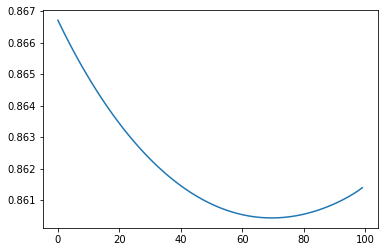

In [13]:
plt.figure()
plt.plot(scores)
plt.show()

In [ ]:
leak_df = pd.read_feather('./leak-v3.feather')
leak_df = leak_df.merge(test_df[['building_id', 'meter', 'timestamp', 'row_id']], left_on = ['building_id', 'meter', 'timestamp'], right_on = ['building_id', 'meter', 'timestamp'], how = "left")
leak_df = leak_df.merge(building_meta_df[['building_id', 'site_id']], on='building_id', how='left')
leak_df.fillna(0, inplace=True)
leak_df = leak_df[(leak_df.timestamp.dt.year > 2016) & (leak_df.timestamp.dt.year < 2019)]
leak_df.loc[leak_df.meter_reading < 0, 'meter_reading'] = 0 # remove large negative values
leak_df = leak_df[leak_df.building_id!=245]

In [ ]:
#check point
check_1_2 = pd.read_feather(os.path.join(root, 'sample_submission.feather'))
check_1_2.to_csv('ensemble4_noleaky1&2_aligncat1_cat5_cleanupcat5_cleanupklgb1.csv', index=False, float_format='%.4f')

In [ ]:
sample_submission = pd.read_feather(os.path.join(root, 'sample_submission.feather'))
sample_submission['meter_reading']= best_weight_1*sample_submission1.meter_reading
sample_submission.loc[sample_submission.meter_reading < 0, 'meter_reading'] = 0
sample_submission['meter_reading'] = best_weight_1* sample_submission1.meter_reading
leak_df = pd.read_feather('./leak-v3.feather')
leak_df = leak_df.merge(test_df[['building_id', 'meter', 'timestamp', 'row_id']], left_on = ['building_id', 'meter', 'timestamp'], right_on = ['building_id', 'meter', 'timestamp'], how = "left")
leak_df = leak_df.merge(building_meta_df[['building_id', 'site_id']], on='building_id', how='left')
leak_df.fillna(0, inplace=True)
leak_df = leak_df[(leak_df.timestamp.dt.year > 2016) & (leak_df.timestamp.dt.year < 2019)]
leak_df.loc[leak_df.meter_reading < 0, 'meter_reading'] = 0 # remove large negative values
leak_df = leak_df[leak_df.building_id!=245]

leak_df = leak_df[['meter_reading', 'row_id']].set_index('row_id').dropna()
sample_submission.loc[leak_df.index, 'meter_reading'] = leak_df['meter_reading']
sample_submission.to_csv('Added_'+sub1+'.csv',index=False, float_format='%.4f')

In [14]:
sample_submission3 = pd.read_csv('./ensemble4_noleaky1&2_aligncat1_cat5.csv', index_col=0)

In [18]:
sample_submission = pd.read_feather(os.path.join(root, 'sample_submission.feather'))
sample_submission.loc[sample_submission.meter_reading < 0, 'meter_reading'] = 0
sample_submission['meter_reading'] = 0.6* best_weight_1* sample_submission1.meter_reading +  0.4*best_weight_2* sample_submission2.meter_reading

leak_df = pd.read_feather('./leak-v3.feather')
leak_df = leak_df.merge(test_df[['building_id', 'meter', 'timestamp', 'row_id']], left_on = ['building_id', 'meter', 'timestamp'], right_on = ['building_id', 'meter', 'timestamp'], how = "left")
leak_df = leak_df.merge(building_meta_df[['building_id', 'site_id']], on='building_id', how='left')
leak_df.fillna(0, inplace=True)
leak_df = leak_df[(leak_df.timestamp.dt.year > 2016) & (leak_df.timestamp.dt.year < 2019)]
leak_df.loc[leak_df.meter_reading < 0, 'meter_reading'] = 0 # remove large negative values
leak_df = leak_df[leak_df.building_id!=245]

leak_df = leak_df[['meter_reading', 'row_id']].set_index('row_id').dropna()
sample_submission.loc[leak_df.index, 'meter_reading'] = leak_df['meter_reading']
sample_submission.to_csv('Added_'+sub1+'_'+sub2+'.csv',index=False, float_format='%.4f')

In [36]:
sample_submission = pd.read_feather(os.path.join(root, 'sample_submission.feather'))
sample_submission.loc[sample_submission.meter_reading < 0, 'meter_reading'] = 0
sample_submission['meter_reading'] = 0.65* best_weight_1* sample_submission1.meter_reading +  0.35*best_weight_2* sample_submission2.meter_reading

sample_submission.to_csv(sub1+'_'+sub2+'.csv',index=False, float_format='%.4f')

In [11]:
'Added_'+sub1+'_'+sub2+'.csv'

'Added_cleanup_Klgb_1_ensemble4_noleaky1&2_aligncat1_cat5_cleanupcat5.csv'